# GAN's From Scratch 

by Kris Smith

# Problem Statement

***This notebook is working towards generating images in the style of a famous artist painter [Claude Monet](https://en.wikipedia.org/wiki/Claude_Monet). This problem is presented as a competition on the Kaggle platform for the sake of learning. We will explore in particular one common approach to this task in the form of [Generative Adversarial Networks(GANs)](https://en.wikipedia.org/wiki/Generative_adversarial_network).***

In [1]:
!pip install albumentations

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
# import matplotlib.pyplot as plt
# import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
# import gdown
from zipfile import ZipFile

import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import albumentations as A

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)

# AUTOTUNE = tf.data.experimental.AUTOTUNE
    
# print(tf.__version__)


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Overview

### Dataset Description
<i>The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.<i>

<i>We recommend using TFRecords as a Getting Started competition is a great way to become more familiar with a new data format, but JPEG images have also been provided.

<i>The monet directories contain Monet paintings. Use these images to train your model.

<i>The photo directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

<i>Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

<i>Check out the CycleGAN dataset to experiment with the artistic style of other artists.</i>

    
### Files
* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
* photo_jpg - 7028 photos sized 256x256 in JPEG format
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format

### Submission format
* Your kernel's output must be called images.zip and contain 7,000-10,000 images sized 256x256.
    
    
### Evaluation
    
MiFID
    
Submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID).

The smaller MiFID is, the better your generated images are.

What is FID?
Originally published here (github), FID, along with Inception Score (IS), are both commonly used in recent publications as the standard for evaluation methods of GANs.

In FID, we use the Inception network to extract features from an intermediate layer. Then we model the data distribution for these features using a multivariate Gaussian distribution with mean µ and covariance Σ. The FID between the real images 𝑟
 and generated images 𝑔
 is computed as:
$$
FID = ||\mu_{r} - \mu_{g}||^{2} + Tr(\Sigma_{r} + \Sigma_{g} - 2(\Sigma_{r}\Sigma_{g})^{1/2})
$$

    
    where 𝑇𝑟 sums up all the diagonal elements. FID is calculated by computing the Fréchet distance between two Gaussians fitted to feature representations of the Inception network.

What is MiFID (Memorization-informed FID)?
In addition to FID, Kaggle takes training sample memorization into account.

The memorization distance is defined as the minimum cosine distance of all training samples in the feature space, averaged across all user generated image samples. This distance is thresholded, and it's assigned to 1.0 if the distance exceeds a pre-defined epsilon.

In mathematical form:
    
$$
d_{ij} = 1 - \cos(f_{gi}, f_{rj}) = 1 - \frac{f_{gi} \cdot f_{rj}}{||f_{gi}|| ||f_{rj}||}
$$
    
where 𝑓𝑔
 and 𝑓𝑟
 represent the generated/real images in feature space (defined in pre-trained networks); and 𝑓𝑔𝑖
 and 𝑓𝑟𝑗
 represent the 𝑖𝑡ℎ
 and 𝑗𝑡ℎ
 vectors of 𝑓𝑔
 and 𝑓𝑟
, respectively.

$$
d = \frac{1}{N} \sum_{i} \min_{j} d_{ij}
$$
    
defines the minimum distance of a certain generated image (𝑖
) across all real images ((𝑗
), then averaged across all the generated images.

enter image description here
defines the threshold of the weight only applies when the (𝑑
) is below a certain empirically determined threshold.

Finally, this memorization term is applied to the FID:
    
$$
MiFID = FID * \frac{1}{d_thr}
$$
    
**Kaggle's workflow calculating MiFID for public and private scores**
    
Kaggle calculates public MiFID scores with the pre-train neural network Inception, and the public images used for evaluation are the rest of the TFDS Monet paintings. ***Note that as a Getting Started competition there is no private leaderboard.***

    
### Submission File
    
You are going to generate 7,000-10,000 Monet-style images that are in jpg format. Their sizes should be 256x256x3 (RGB). Then you need to zip those images and your output from your Kernel should only have ONE output file named images.zip.

Please note that Kaggle Kernels has a number of output files capped at 500. We highly encourage you to either directly write to a zip file as you generate images, or create a folder at ../tmp as your temporary directory.


---

# Data

## EDA

In [2]:
BASE_PATH = "../input/gan-getting-started/"
MONET_PATH = os.path.join(BASE_PATH, "monet_jpg")
PHOTO_PATH = os.path.join(BASE_PATH, "photo_jpg")

***Image statistics. The following function was provided by the following notebook: https://www.kaggle.com/code/ihelon/monet-visualization-and-augmentation. This function displays the number of images in the monet and photo folders along with their attributes.***

In [3]:
def print_folder_statistics(path):
    d_image_sizes = {}
    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        d_image_sizes[image.shape] = d_image_sizes.get(image.shape, 0) + 1
        
    for size, count in d_image_sizes.items():
        print(f"shape: {size}\tcount: {count}")


print(f"Monet images:")
print_folder_statistics(MONET_PATH)
print("-" * 10)
print(f"Photo images:")
print_folder_statistics(PHOTO_PATH)
print("-" * 10)

Monet images:
shape: (256, 256, 3)	count: 300
----------
Photo images:
shape: (256, 256, 3)	count: 7038
----------


***We will focus mainly on the monet images for now. We can see that we are working with 300 of them and each image is 256x256 pixels with 3 channels of color(RGB).***

### Load Data

In [4]:
dataset = keras.utils.image_dataset_from_directory(
    MONET_PATH, 
    label_mode=None, 
    image_size=(256, 256), 
    batch_size=8
)
dataset = dataset.map(lambda x: x / 255.0)

Found 300 files belonging to 1 classes.


### Inspecting Images

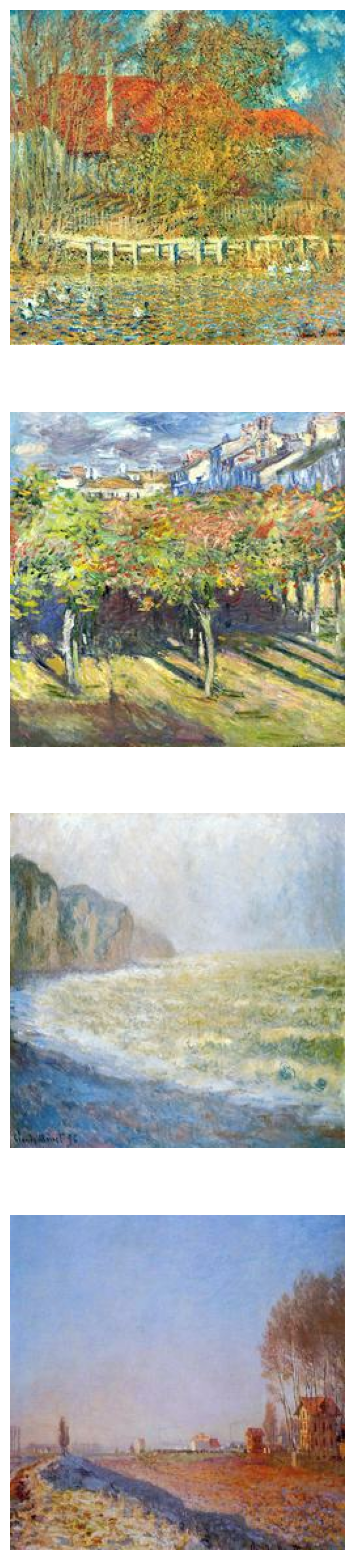

In [5]:
## Choose the number of images to display
n = 4

## Create a temporary dataset to stop iteration after the first batch
dataset_temp = iter(dataset)

## Fetch the first batch
x = next(dataset_temp)

## Make sure the data is in the correct format
if isinstance(x, tuple):
    x = x[0]  

fig, axes = plt.subplots(n, 1, figsize=(20, 20))

for i in range(n):
    img = x[i].numpy()
    img = (img * 255).astype("int32")
    axes[i].axis("off")
    axes[i].imshow(img)

plt.show()

### Feature Engineering

In [6]:


# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_addons as tfa
# import tensorflow_datasets as tfds

from kaggle_datasets import KaggleDatasets
# import matplotlib.pyplot as plt
# import numpy as np

# from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

# print(tf.__version__)
# Load in the data
# We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords. We'll load both for the CycleGAN. For the first GAN we only need the Monets as training data.

# All the images for the competition are already sized to 256 x 256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

# GCS_PATH = KaggleDatasets().get_gcs_path()

# MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
# print('Monet TFRecord Files:', len(MONET_FILENAMES))
# You can see I put down a bit of augmentation using random_jitter and flip to increase our data set, because we simply don't have enough data for

IMAGE_SIZE = [256, 256]

def normalize(image):
    return (tf.cast(image, tf.float32) / 127.5) - 1

def decode_image(image):
    #image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.reshape(image, [256, 256, 3])
    image = tf.image.decode_jpeg(image, channels=3)
    #image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[256, 256, 3])
    return cropped_image

def random_jitter(image):
    # resizing to 286 x 286 x 3 
    image = tf.image.resize(image, [int(256*1.3), int(256*1.3)],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)
    # random mirroring
    return image

def flip(image):
    return tf.image.flip_left_right(image)

def preprocess_image_train(image, label=None):
    image = random_jitter(image)
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=False, ordered=False, repeats=200):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.concatenate(dataset.map(flip, num_parallel_calls=AUTOTUNE).shuffle(100000))
    dataset = dataset.concatenate(dataset.map(random_jitter, num_parallel_calls=AUTOTUNE).shuffle(100000, reshuffle_each_iteration=True).repeat(repeats))
    dataset = dataset.map(normalize, num_parallel_calls=AUTOTUNE).shuffle(100000)
    return dataset


# monet_ds = load_dataset(tf.io.gfile.glob(str(KaggleDatasets().get_gcs_path() + '/monet_tfrec/*.tfrec')),
#                         labeled=True, 
#                         repeats=150).batch(150, drop_remainder=True)
# monet_ds

## Create the discriminator

It maps a 256x256 image to a binary classification score.

In [7]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 256)     12544     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 256)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 512)       2097664   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 512)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 512)       4194816   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 512)       0         
                                                                 
 flatten (Flatten)           (None, 524288)          

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [8]:
latent_dim = 512

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 512),
        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             16809984  
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 512)      4194816   
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      2097408   
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [9]:

# class GAN(keras.Model):
#     def __init__(self, discriminator, generator, latent_dim):
#         super().__init__()
#         self.discriminator = discriminator
#         self.generator = generator
#         self.latent_dim = latent_dim

#     def compile(self, d_optimizer, g_optimizer, loss_fn):
#         super().compile()
#         self.d_optimizer = d_optimizer
#         self.g_optimizer = g_optimizer
#         self.loss_fn = loss_fn
#         self.d_loss_metric = keras.metrics.Mean(name="d_loss")
#         self.g_loss_metric = keras.metrics.Mean(name="g_loss")

#     @property
#     def metrics(self):
#         return [self.d_loss_metric, self.g_loss_metric]

#     def train_step(self, real_images):
#         # Sample random points in the latent space
#         batch_size = tf.shape(real_images)[0]
#         random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

#         # Decode them to fake images
#         generated_images = self.generator(random_latent_vectors)

#         # Combine them with real images
#         combined_images = tf.concat([generated_images, real_images], axis=0)

#         # Assemble labels discriminating real from fake images
#         labels = tf.concat(
#             [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
#         )
#         # Add random noise to the labels - important trick!
#         labels += 0.05 * tf.random.uniform(tf.shape(labels))

#         # Train the discriminator
#         with tf.GradientTape() as tape:
#             predictions = self.discriminator(combined_images)
#             d_loss = self.loss_fn(labels, predictions)
#         grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
#         self.d_optimizer.apply_gradients(
#             zip(grads, self.discriminator.trainable_weights)
#         )

#         # Sample random points in the latent space
#         random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

#         # Assemble labels that say "all real images"
#         misleading_labels = tf.zeros((batch_size, 1))

#         # Train the generator (note that we should *not* update the weights
#         # of the discriminator)!
#         with tf.GradientTape() as tape:
#             predictions = self.discriminator(self.generator(random_latent_vectors))
#             g_loss = self.loss_fn(misleading_labels, predictions)
#         grads = tape.gradient(g_loss, self.generator.trainable_weights)
#         self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

#         # Update metrics
#         self.d_loss_metric.update_state(d_loss)
#         self.g_loss_metric.update_state(g_loss)
#         return {
#             "d_loss": self.d_loss_metric.result(),
#             "g_loss": self.g_loss_metric.result(),
#         }


In [10]:
class BiGAN(keras.Model):
    def __init__(self, discriminator, generator, encoder, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.encoder = encoder
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, e_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.e_optimizer = e_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        self.e_loss_metric = keras.metrics.Mean(name="e_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric, self.e_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        # Encode real images to latent vectors
        encoded_latent_vectors = self.encoder(real_images)

        # Combine them with real images
        fake_and_real_images = tf.concat([generated_images, real_images], axis=0)
        # Combine them with latent vectors
        encoded_and_random_latent_vectors = tf.concat([encoded_latent_vectors, random_latent_vectors], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([fake_and_real_images, encoded_and_random_latent_vectors])
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator([self.generator(random_latent_vectors), random_latent_vectors])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Train the encoder (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator([real_images, self.encoder(real_images)])
            e_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(e_loss, self.encoder.trainable_weights)
        self.e_optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        self.e_loss_metric.update_state(e_loss)
        
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
            "e_loss": self.e_loss_metric.result(),
        }

In [11]:

# class GANMonitor(keras.callbacks.Callback):
#     def __init__(self, num_img=3, latent_dim=512):
#         self.num_img = num_img
#         self.latent_dim = latent_dim

#     def on_epoch_end(self, epoch, logs=None):
#         random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
#         generated_images = self.model.generator(random_latent_vectors)
#         generated_images *= 255
#         generated_images.numpy()
#         for i in range(self.num_img):
#             img = keras.utils.array_to_img(generated_images[i])
#             img.save("generated_img_%03d_%d.png" % (epoch, i))


In [12]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=512):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.test_data = None

    def set_test_data(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs=None):
        # Check if test_data is set
        if self.test_data is not None:
            # Retrieve a batch of data from the dataset
            real_images = next(iter(self.test_data.take(self.num_img)))
            
            # Encode the real images to obtain the latent vectors
            encoded_latent_vectors = self.model.encoder(real_images)
            
            # Generate images from the encoded latent vectors
            generated_images = self.model.generator(encoded_latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            for i in range(self.num_img):
                img = keras.utils.array_to_img(generated_images[i])
                img.save("generated_img_%03d_%d.png" % (epoch, i))

In [13]:
# epochs = 2  # In practice, use ~100 epochs

# gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
# gan.compile(
#     d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#     g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#     loss_fn=keras.losses.BinaryCrossentropy(),
# )

# gan.fit(
#     dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
# )

In [14]:
encoder = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(latent_dim),
    ],
    name="encoder",
)

In [15]:
# epochs = 2  # In practice, use ~100 epochs

# test_data = ...  # Insert your test data here

# gan = AE_GAN(discriminator=discriminator, generator=generator, encoder=encoder, latent_dim=latent_dim)
# gan.compile(
#     d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#     g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#     loss_fn=keras.losses.BinaryCrossentropy(),
# )

# gan.fit(
#     dataset, 
#     epochs=epochs, 
#     callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim, test_data=test_data)]
# )

In [16]:
input_img = layers.Input(shape=(256, 256, 3))
input_z = layers.Input(shape=(latent_dim,))

# image processing
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(input_img)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Flatten()(x)

# latent vector processing
y = layers.Dense(512)(input_z)
y = layers.LeakyReLU(alpha=0.2)(y)

# combining the outputs
combined = layers.Concatenate()([x, y])
output = layers.Dense(1, activation="sigmoid")(combined)

discriminator = keras.Model([input_img, input_z], output, name="discriminator")

Epoch 1/2
38/38 [==============================] - 25s 264ms/step - d_loss: 8.0676 - g_loss: 14.1261 - e_loss: 3.8414
Epoch 2/2
38/38 [==============================] - 9s 241ms/step - d_loss: 6.0215 - g_loss: 2.5103 - e_loss: 1.4998


In [ ]:
############################################
epochs = 50  

gan = BiGAN(discriminator=discriminator, generator=generator, encoder=encoder, latent_dim=latent_dim)
gan.compile(
    e_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, 
    epochs=epochs, 
    callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/50
10/38 [======>.......................] - ETA: 6s - d_loss: 0.9927 - g_loss: 2.5730 - e_loss: 0.9618

In [ ]:
PHOTO_FILENAMES = tf.io.gfile.glob(str(KaggleDatasets().get_gcs_path() + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset


photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    # Encode the input image
    encoded_img = gan.encoder(img)

    # Generate the prediction using the generator
    prediction = gan.generator(encoded_img)[0].numpy()

    # Post-process the images
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = img[0].numpy().astype('float32')
    img = (img * 127.5 + 127.5).astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
import PIL
! mkdir ../images

In [32]:
# i = 1
# for img in photo_ds:
#     prediction = gan.generator(img, training=False)[0].numpy()
#     prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
#     im = PIL.Image.fromarray(prediction)
#     im.save("../images/" + str(i) + ".jpg")
#     i += 1

In [38]:
i = 1
for img in photo_ds:
    if i % 350 == 0:
        print(f"{round(i/7038*100)}% Complete")

    # Encode the input image
    encoded_img = gan.encoder(img)
    
    # Generate the prediction using the generator
    prediction = gan.generator(encoded_img)[0].numpy()
    
    # Post-process the images
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    
    # Convert numpy array to image and save it
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

1% Complete
3% Complete
4% Complete
6% Complete
7% Complete
9% Complete
10% Complete
11% Complete
13% Complete
14% Complete
16% Complete
17% Complete
18% Complete
20% Complete
21% Complete
23% Complete
24% Complete
26% Complete
27% Complete
28% Complete
30% Complete
31% Complete
33% Complete
34% Complete
36% Complete
37% Complete
38% Complete
40% Complete
41% Complete
43% Complete
44% Complete
45% Complete
47% Complete
48% Complete
50% Complete
51% Complete
53% Complete
54% Complete
55% Complete
57% Complete
58% Complete
60% Complete
61% Complete
63% Complete
64% Complete
65% Complete
67% Complete
68% Complete
70% Complete
71% Complete
72% Complete
74% Complete
75% Complete
77% Complete
78% Complete
80% Complete
81% Complete
82% Complete
84% Complete
85% Complete
87% Complete
88% Complete
90% Complete
91% Complete
92% Complete
94% Complete
95% Complete
97% Complete
98% Complete
99% Complete


In [39]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

In [26]:
# Save model weights
gan.save_weights('bigan_weights')
gan.generator.save_weights('bigan_generator_weights')
gan.discriminator.save_weights('bigan_discriminator_weights')
gan.encoder.save_weights('bigan_encoder_weights')

# Load model weights
# gan.load_weights('bigan_weights')
# gan.generator.load_weights('bigan_generator_weights')
# gan.discriminator.load_weights('bigan_discriminator_weights')
# gan.encoder.load_weights('bigan_encoder_weights')